# Near-Surface Air Temperature

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]


In [2]:
# from dask.distributed import Client
# client = Client()
# client

## Set variables

In [3]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['annual', 'DJFMA', 'JJAS']
# seasons = ['annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

var = 'tas'
table = u.get_table(var)
label, units, cmap, levels = u.get_var_infos(var)
label

'Near-Surface Air Temperature'

## Load topography

In [4]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
cru_ts4.00: https://crudata.uea.ac.uk/cru/data/hrg/

In [5]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period, lat=latlim_ext, lon=lonlim_ext).tmp

temp = []
for season in seasons:
    temp.append(
        u.clim(obs, calendar=obs.time.encoding['calendar'], season=season)
    )

obs_clim = xr.combine_nested(temp, concat_dim='season')
# obs_clim[0].plot()

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [6]:
regridder = xe.Regridder(obs_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_clim_regrid = regridder(obs_clim)
obs_clim_regrid.attrs['long_name'] = 'Air Temperature'
obs_clim_regrid.attrs['units'] = units

Reuse existing file: bilinear_70x120_35x60.nc


[#Load-results](#Load-results)

## Load models

In [126]:
list_models = u.get_model_names()
# list_models = list_models[:1]
# list_models = ['EC-Earth3']

# Create empty lists for storing results before to concatenate them (for models + ensemble mean and seasons)
# Be carefull with *, see https://snakify.org/fr/lessons/two_dimensional_lists_arrays/#section_2
resolution = [None]*(len(list_models)+1)
bias = [[None] * (len(list_models)+1) for i in range(len(seasons))]
rmse = [[None] * (len(list_models)+1) for i in range(len(seasons))]
mb = [[None] * (len(list_models)+1) for i in range(len(seasons))]

for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    ds = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
        combine='by_coords').sel(time=period, lat=latlim_ext, lon=lonlim_ext)[var]
    
    # Check if the time steps are ok
    np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)
    
    # Print resolution and save it
    lat = (ds.lat[1] - ds.lat[0]).values; lon = (ds.lon[1] - ds.lon[0]).values
    print(str(lat.round(3))+'°x'+str(lon.round(3))+'°')
    resolution[i] = str(lat.round(1))+'°x'+str(lon.round(1))+'°'
    
    # Make regridder
    regridder = xe.Regridder(ds, elevation, 'bilinear', periodic=False, reuse_weights=True)
    
    for k, season in enumerate(seasons):
        print(season)
        # Compute climatology
        model_clim = u.clim(ds, calendar=calendar, season=season) - 273.15

        # Regrid towards elevation grid 1°x1°
        model_clim_regrid = regridder(model_clim)

        # Compute the bias (k for season, i for model)
        bias[k][i] = (model_clim_regrid - obs_clim_regrid.sel(season=season)).sel(lat=latlim, lon=lonlim).load()
        
        # Compute the pattern/spatial area-weighted RMSE and mean bias
        rmse[k][i] = np.sqrt(u.spatial_average(bias[k][i].where(elevation > 2500)**2))
        mb[k][i] = u.spatial_average(bias[k][i].where(elevation > 2500))
        
    print('\n')

BCC-CSM2-MR(1/34)
1.121°x1.125°
Reuse existing file: bilinear_32x54_35x60.nc
annual
DJFMA
JJAS


BCC-ESM1(2/34)
2.791°x2.812°
Reuse existing file: bilinear_13x21_35x60.nc
annual
DJFMA
JJAS


CAS-ESM2-0(3/34)
1.417°x1.406°
Reuse existing file: bilinear_24x42_35x60.nc
annual
DJFMA
JJAS


CESM2(4/34)


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


0.942°x1.25°
Reuse existing file: bilinear_37x49_35x60.nc
annual
DJFMA
JJAS


CESM2-FV2(5/34)


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


1.895°x2.5°
Reuse existing file: bilinear_18x25_35x60.nc
annual
DJFMA
JJAS


CESM2-WACCM(6/34)
0.942°x1.25°
Reuse existing file: bilinear_37x49_35x60.nc
annual


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


DJFMA
JJAS


CESM2-WACCM-FV2(7/34)


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


1.895°x2.5°
Reuse existing file: bilinear_18x25_35x60.nc
annual
DJFMA
JJAS


CIESM(8/34)
0.942°x1.25°
Reuse existing file: bilinear_37x49_35x60.nc
annual
DJFMA
JJAS


CNRM-CM6-1(9/34)
1.401°x1.406°
Reuse existing file: bilinear_25x42_35x60.nc
annual
DJFMA
JJAS


CNRM-CM6-1-HR(10/34)
0.499°x0.5°
Reuse existing file: bilinear_70x121_35x60.nc
annual
DJFMA
JJAS


CNRM-ESM2-1(11/34)
1.401°x1.406°
Reuse existing file: bilinear_25x42_35x60.nc
annual
DJFMA
JJAS


CanESM5(12/34)
2.791°x2.812°
Reuse existing file: bilinear_13x21_35x60.nc
annual
DJFMA
JJAS


CanESM5-CanOE(13/34)
2.791°x2.812°
Reuse existing file: bilinear_13x21_35x60.nc
annual
DJFMA
JJAS


EC-Earth3(14/34)
0.702°x0.703°
Reuse existing file: bilinear_50x85_35x60.nc
annual
DJFMA
JJAS


EC-Earth3-Veg(15/34)
0.702°x0.703°
Reuse existing file: bilinear_50x85_35x60.nc
annual
DJFMA
JJAS


FGOALS-f3-L(16/34)
1.0°x1.25°
Reuse existing file: bilinear_35x48_35x60.nc
annual
DJFMA
JJAS


GFDL-CM4(17/34)
1.0°x1.25°
Reuse existing file: bilinea

## Make multi-model ensemble and average

In [127]:
# Index -1 is for mmm (Multi-Model Mean)

temp = [None] * len(seasons)
for k, season in enumerate(seasons):
    # Concatenate the multimodel ensemble (bias[k][:-1] not to take the last indice for mmm that is None)
    multimodel_ensemble_bias = xr.concat(
        bias[k][:-1], pd.Index(list_models, name="model"), coords='minimal', compat='override'
    )

    # Compute multimodel mean
    mmm_bias = multimodel_ensemble_bias.mean('model')
    
    # Add resolution
    resolution[-1] = '1°x1°'
    
    # Add the bias and metrics in position -1 (for mmm)
    bias[k][-1] = mmm_bias
    rmse[k][-1] = np.sqrt(u.spatial_average(mmm_bias.where(elevation > 2500)**2))
    mb[k][-1] = u.spatial_average(mmm_bias.where(elevation > 2500))

    list_models_mmm = list_models.copy()
    list_models_mmm.append('multi-model mean')


    # Concatenate the mmm of the multimodel_ensemble_bias
    temp[k] = xr.concat(
        bias[k], pd.Index(list_models_mmm, name="model"), coords='minimal', compat='override'
    )

    # Add the rmse and mb as coordinates
    temp[k] = temp[k].assign_coords({
        'rmse': ('model', rmse[k]),
        'mean_bias': ('model', mb[k]),
        'resolution': ('model', resolution),
    })
    
    
# Concatenate the mmm of the multimodel_ensemble_bias
multimodel_ensemble_bias_mmm = xr.concat(temp, pd.Index(seasons, name="season"))

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Save results

In [138]:
multimodel_ensemble_bias_mmm.to_netcdf(
    'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
)

## Load results

In [7]:
# mmm: multimodel mean (is at the last index)

multimodel_ensemble_bias_mmm = xr.open_dataarray(
    'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
)
# multimodel_ensemble_mmm

## Check min and max

### Model

In [8]:
multimodel_ensemble_bias_mmm.min().values, multimodel_ensemble_bias_mmm.max().values

(array(-21.74959888), array(18.96704451))

In [9]:
for season in seasons:
    print(
        season,
        multimodel_ensemble_bias_mmm.sel(season=season).min().values, 
        multimodel_ensemble_bias_mmm.sel(season=season).max().values
    )

annual -19.54830552761225 16.07515667934537
DJFMA -21.74959888066706 15.77849552763603
JJAS -18.401137542993204 18.967044511365586


### Obs

In [10]:
obs_clim_regrid.min().values, obs_clim_regrid.max().values

(array(-20.41296478), array(34.18475899))

In [11]:
for season in seasons:
    print(
        season,
        obs_clim_regrid.sel(season=season).min().values, 
        obs_clim_regrid.sel(season=season).max().values
    )

annual -8.249703437902586 28.721085317380656
DJFMA -20.41296477826412 27.982576190091375
JJAS 2.0414049945883086 34.184758987578675


## Make final plots (for each season)

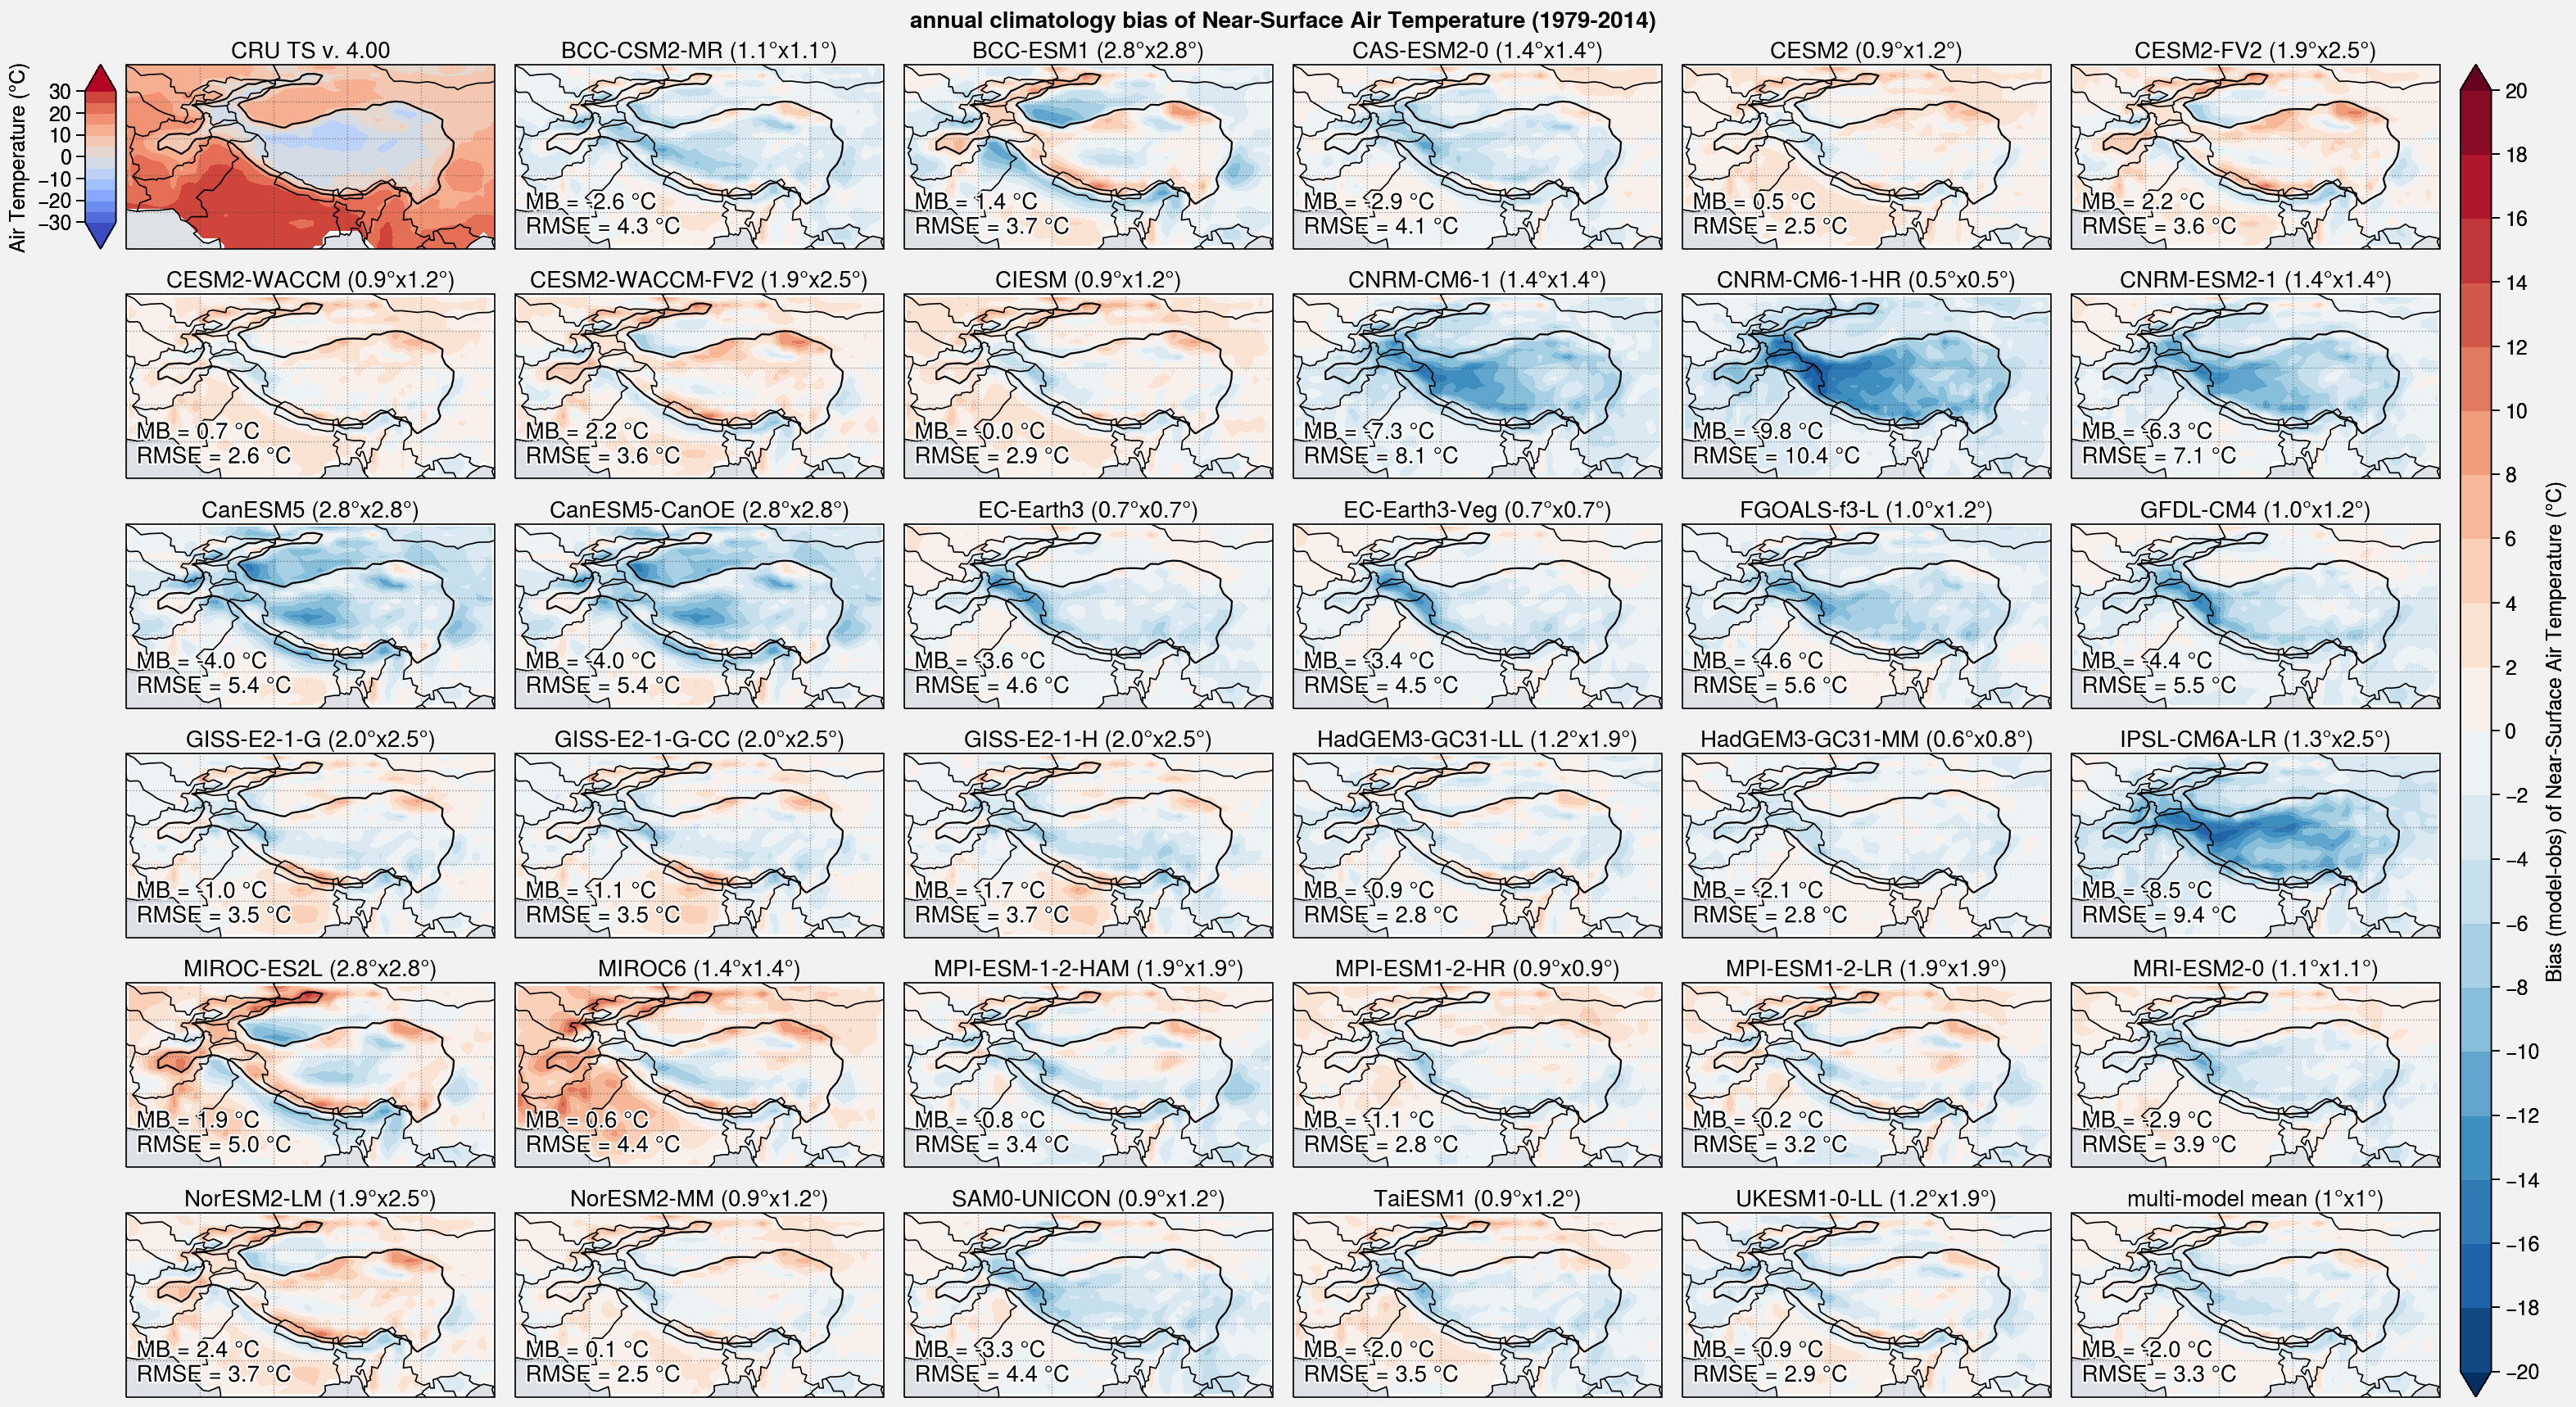

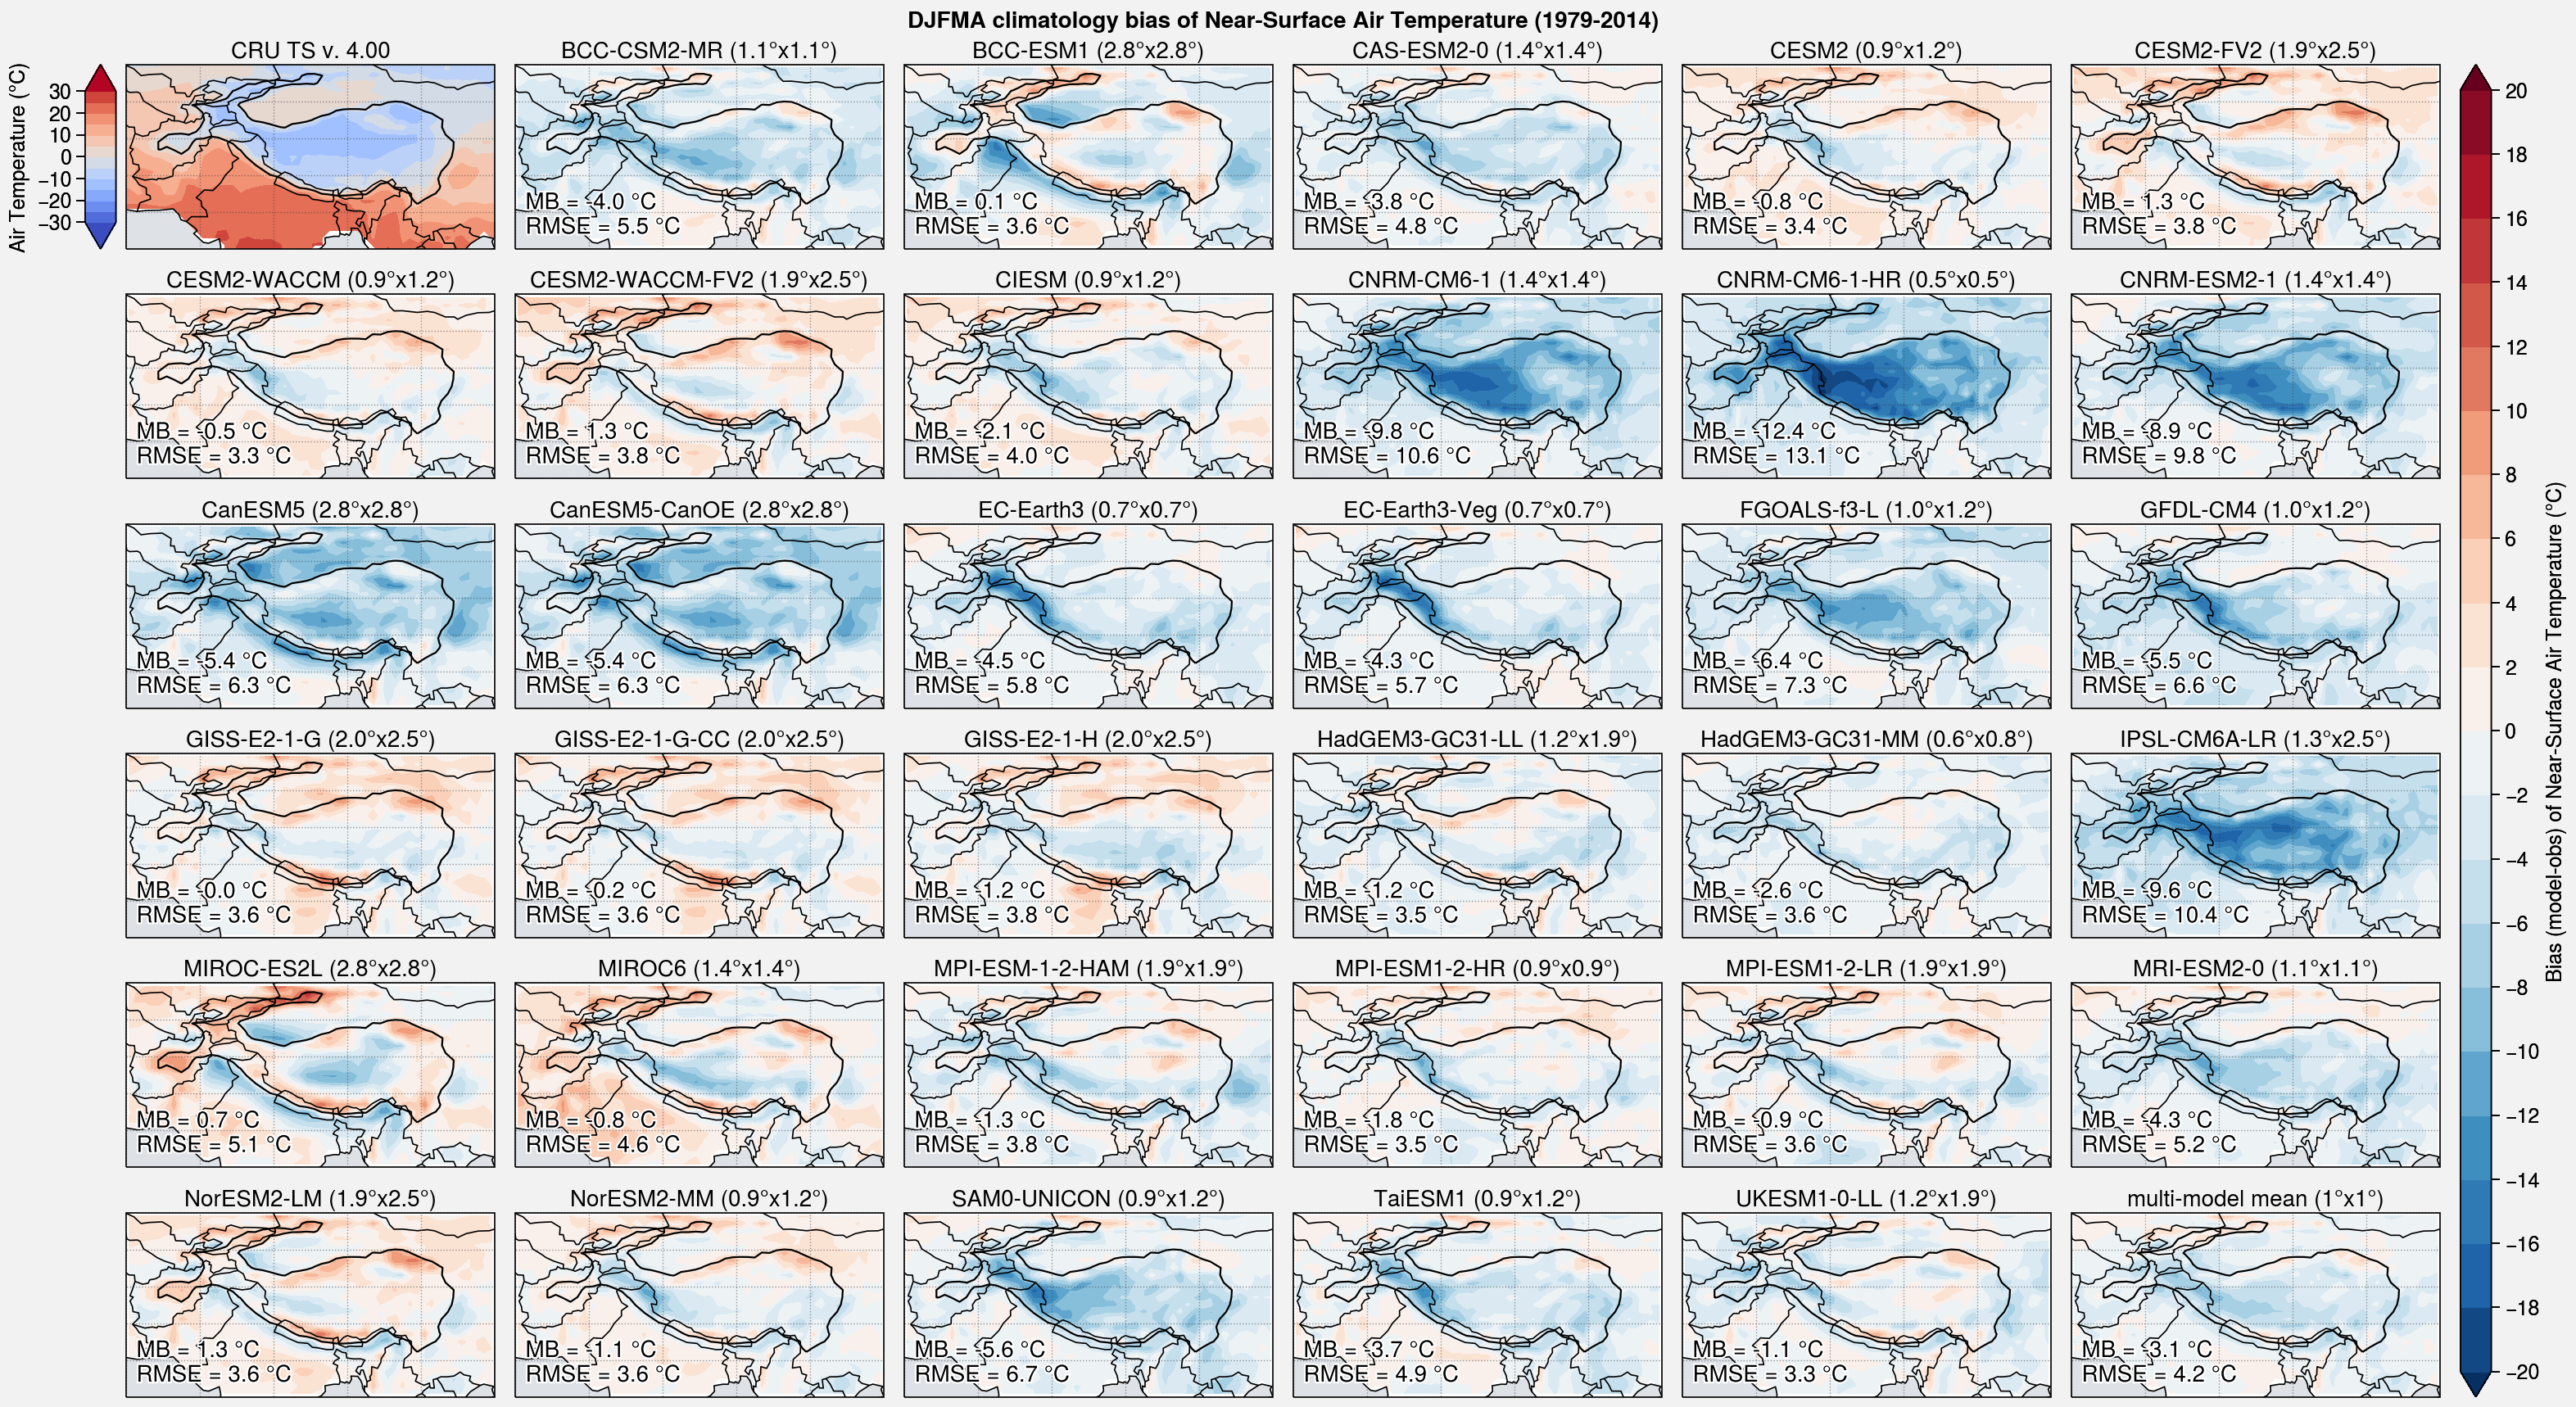

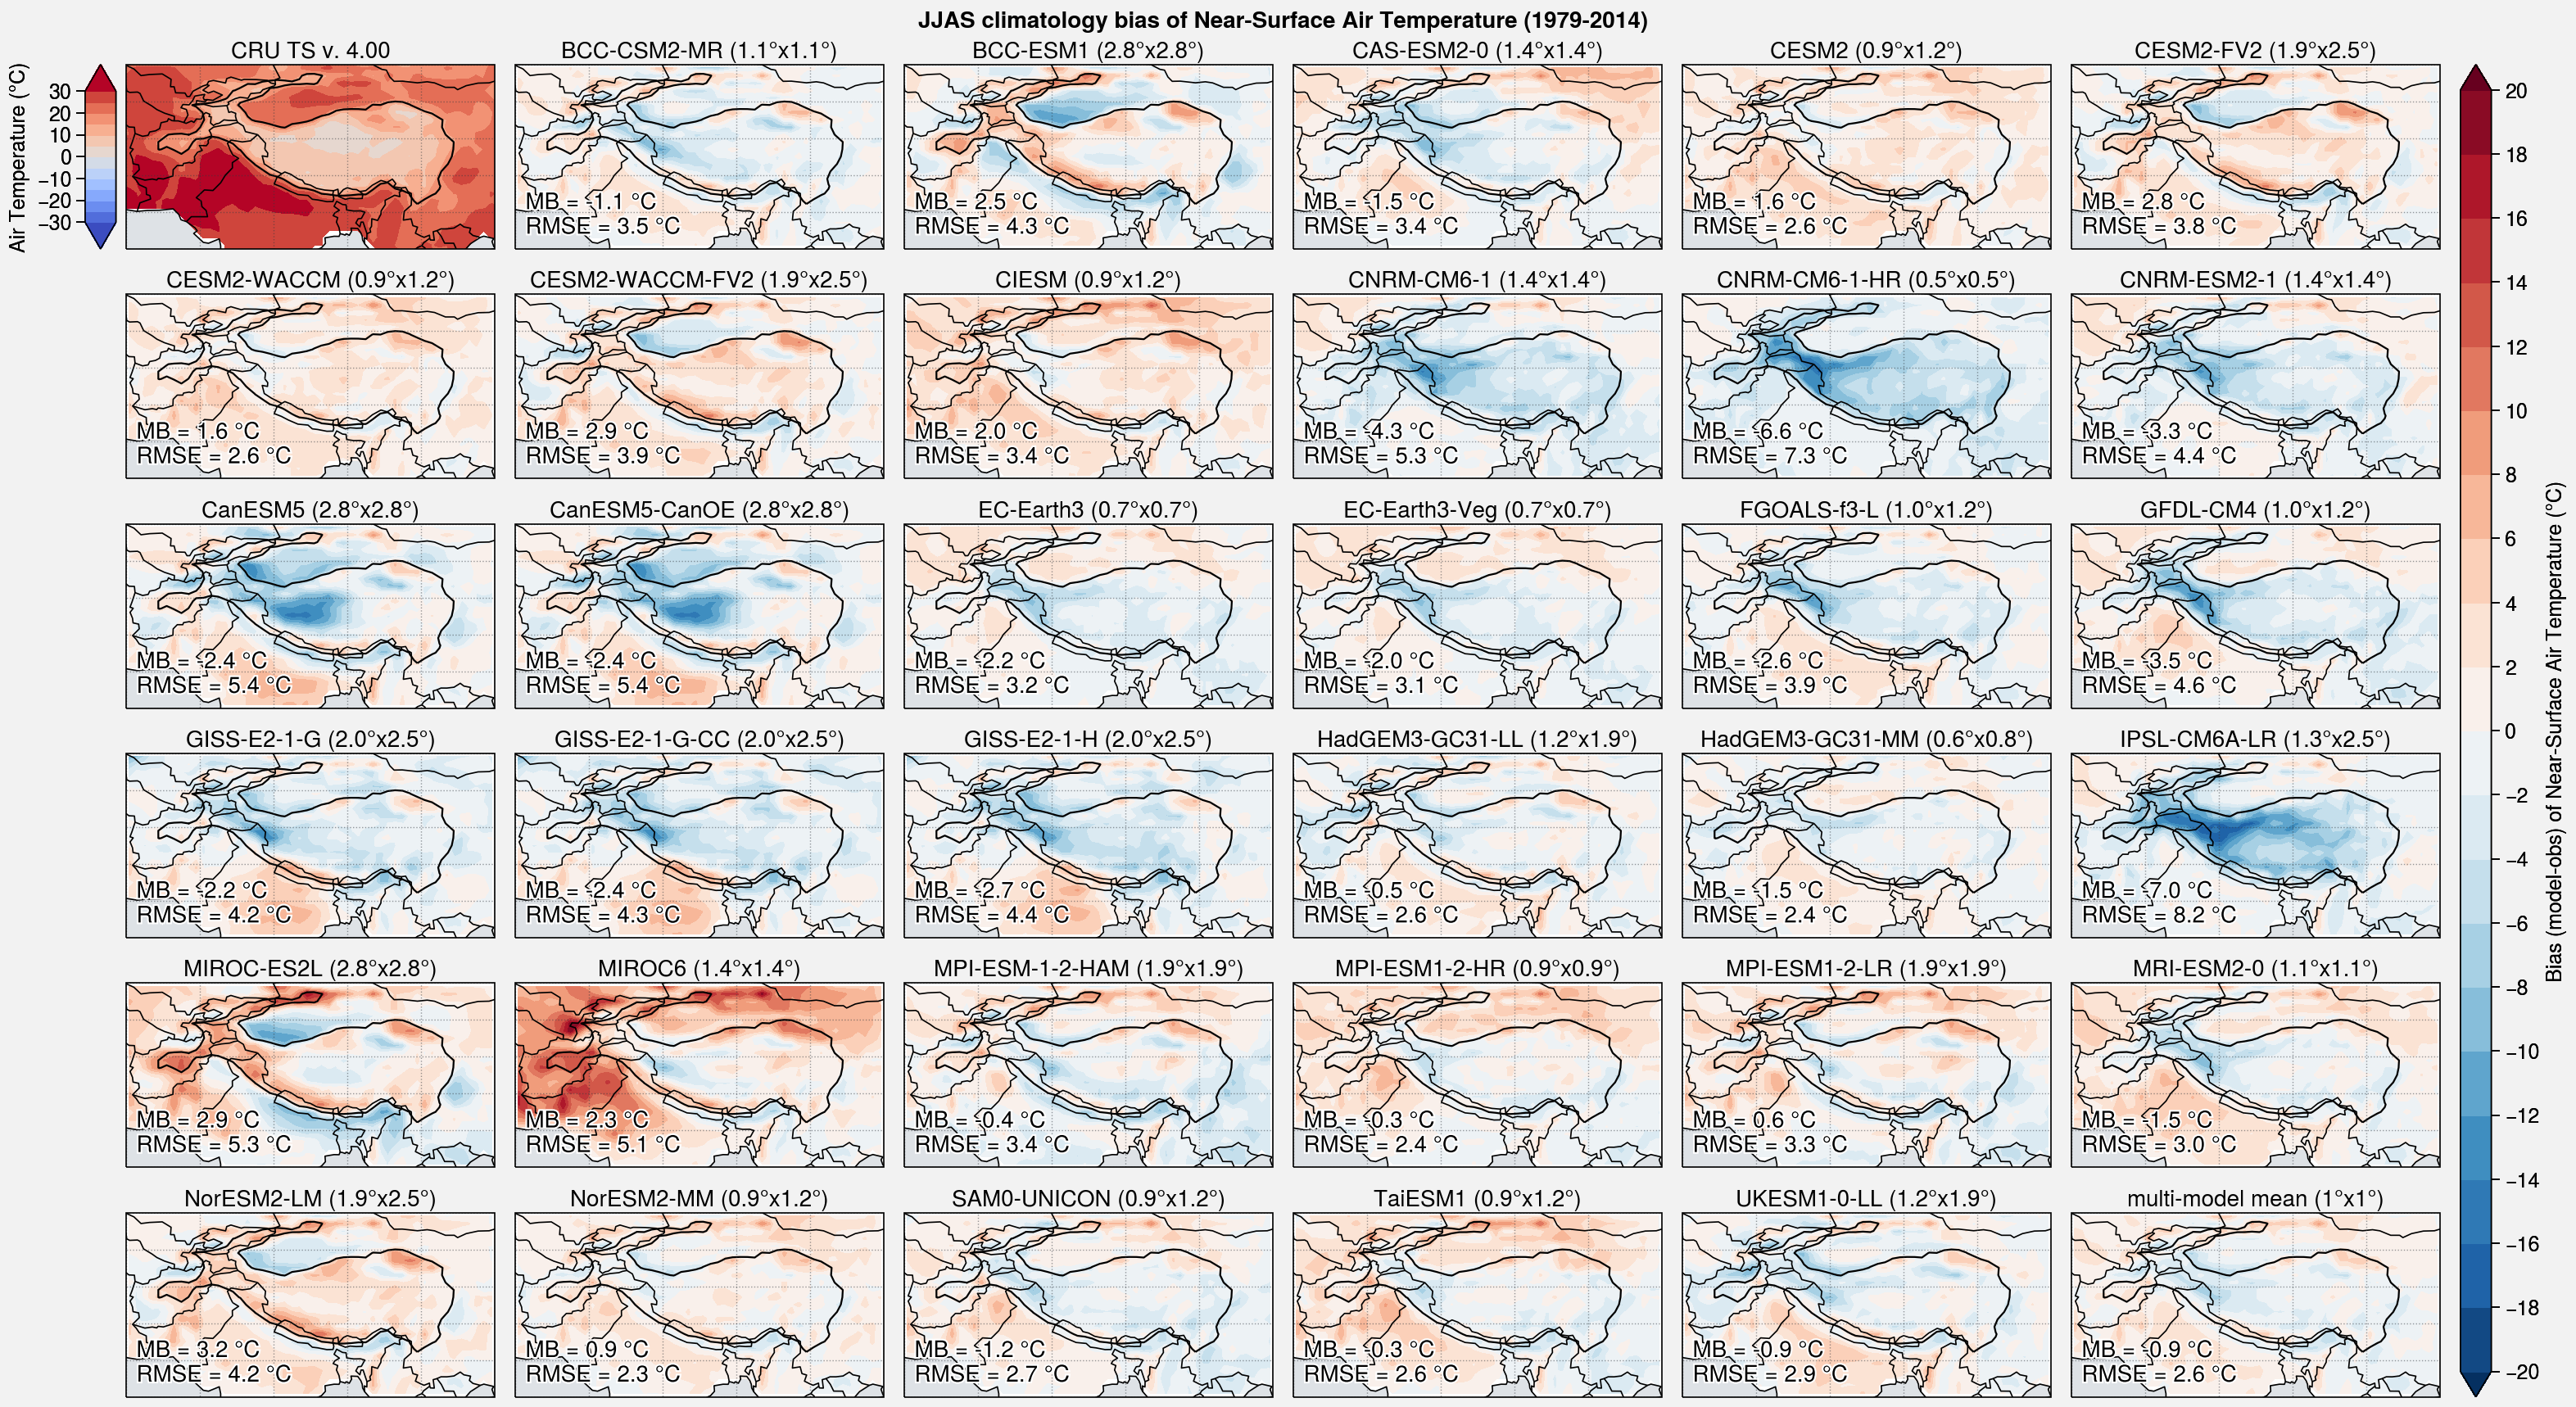

In [148]:
for season in seasons:
    f, axs = plot.subplots(proj='cyl', ncols=6, nrows=6)

    for i, ax in enumerate(axs):
        # Add contour 2500 m
        ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

        # Plot observation
        if i == 0:
            ax.contourf(
                obs_clim_regrid.sel(season=season), cmap=cmap, levels=levels, colorbar='l', extend='both'
            )
            ax.format(title=obs_longname)

        # Plot model bias
        else:
            # Plot ([i-1] because the first plot is the obs)
            m = ax.contourf(
                multimodel_ensemble_bias_mmm.sel(season=season)[i-1], 
                cmap = 'RdBu_r', 
                levels = plot.arange(-20,20,2),
                extend = 'both'
            ),
                
            
            # Text
            ax.format(
                # Title: model name + resolution
                title = str(
                    multimodel_ensemble_bias_mmm.sel(season=season).model[i-1].values
                )+' ('+str(
                    multimodel_ensemble_bias_mmm.sel(season=season).resolution[i-1].values
                )+')',
                
                # Lower left title: mean bias + RMSE
                lltitle = 'MB = '+str(
                    multimodel_ensemble_bias_mmm.sel(season=season).mean_bias[i-1].round(1).values
                ) +' °C\nRMSE = '+str(
                             multimodel_ensemble_bias_mmm.sel(season=season).rmse[i-1].round(1).values
                ) +' °C'
            )

    f.colorbar(m, label='Bias (model-obs) of '+label+' ('+units+')', loc='r')

    axs.format(
        # Grids, labels and limits
        geogridlinewidth = 0.5, geogridcolor = 'gray8', geogridalpha = 0.5, labels = False,
        lonlines=10, latlines=5, latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
        
        # Add coast, ocean, borders
        coast = True, ocean = True, oceancolor = 'gray3', borders = True,
        
        # Suptitle
        suptitle = season+' climatology bias of '+label+' ('+period.start+'-'+period.stop+')'   
    )
    
    filename = season+'_clim_bias_'+var+'_'+period.start+'-'+period.stop
    f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

# Mean bias

In [165]:
# Data shape (season, model, metric)

list_data = [None]*len(seasons)

# Try to keep the multimodel mean separate
model_sorted_annual = multimodel_ensemble_bias_mmm.sel(season='annual')[:-1].sortby(
                      'rmse', ascending=False).model.values
model_sorted_annual = np.insert(model_sorted_annual, 0, multimodel_ensemble_bias_mmm.model[-1].values)

for i, season in enumerate(seasons):
    data = np.ndarray(shape=(multimodel_ensemble_bias_mmm.model.size, 2))
    
#     data[:,0] = multimodel_ensemble_bias_mmm.sel(season=season).sortby('rmse', ascending=False).rmse
#     data[:,1] = multimodel_ensemble_bias_mmm.sel(season=season).sortby('rmse', ascending=False).mean_bias

    data[:,0] = multimodel_ensemble_bias_mmm.sel(season=season).reindex(model=model_sorted_annual).rmse
    data[:,1] = multimodel_ensemble_bias_mmm.sel(season=season).reindex(model=model_sorted_annual).mean_bias

    list_data[i] = pd.DataFrame(
        data, columns=pd.Index(['RMSE', 'Mean Bias'], name='Metric'),
        index=pd.Index(model_sorted_annual, name='Model')
    )

# data

In [134]:
for i, season in enumerate(seasons):
    print(season)
    print(list_data[i].min())
    print(list_data[i].max())
    print('\n')

annual
Metric
RMSE         2.538343
Mean Bias   -9.807472
dtype: float64
Metric
RMSE         10.434731
Mean Bias     2.359489
dtype: float64


DJFMA
Metric
RMSE          3.257705
Mean Bias   -12.408581
dtype: float64
Metric
RMSE         13.052595
Mean Bias     1.310113
dtype: float64


JJAS
Metric
RMSE         2.281287
Mean Bias   -6.965480
dtype: float64
Metric
RMSE         8.214292
Mean Bias    3.196422
dtype: float64




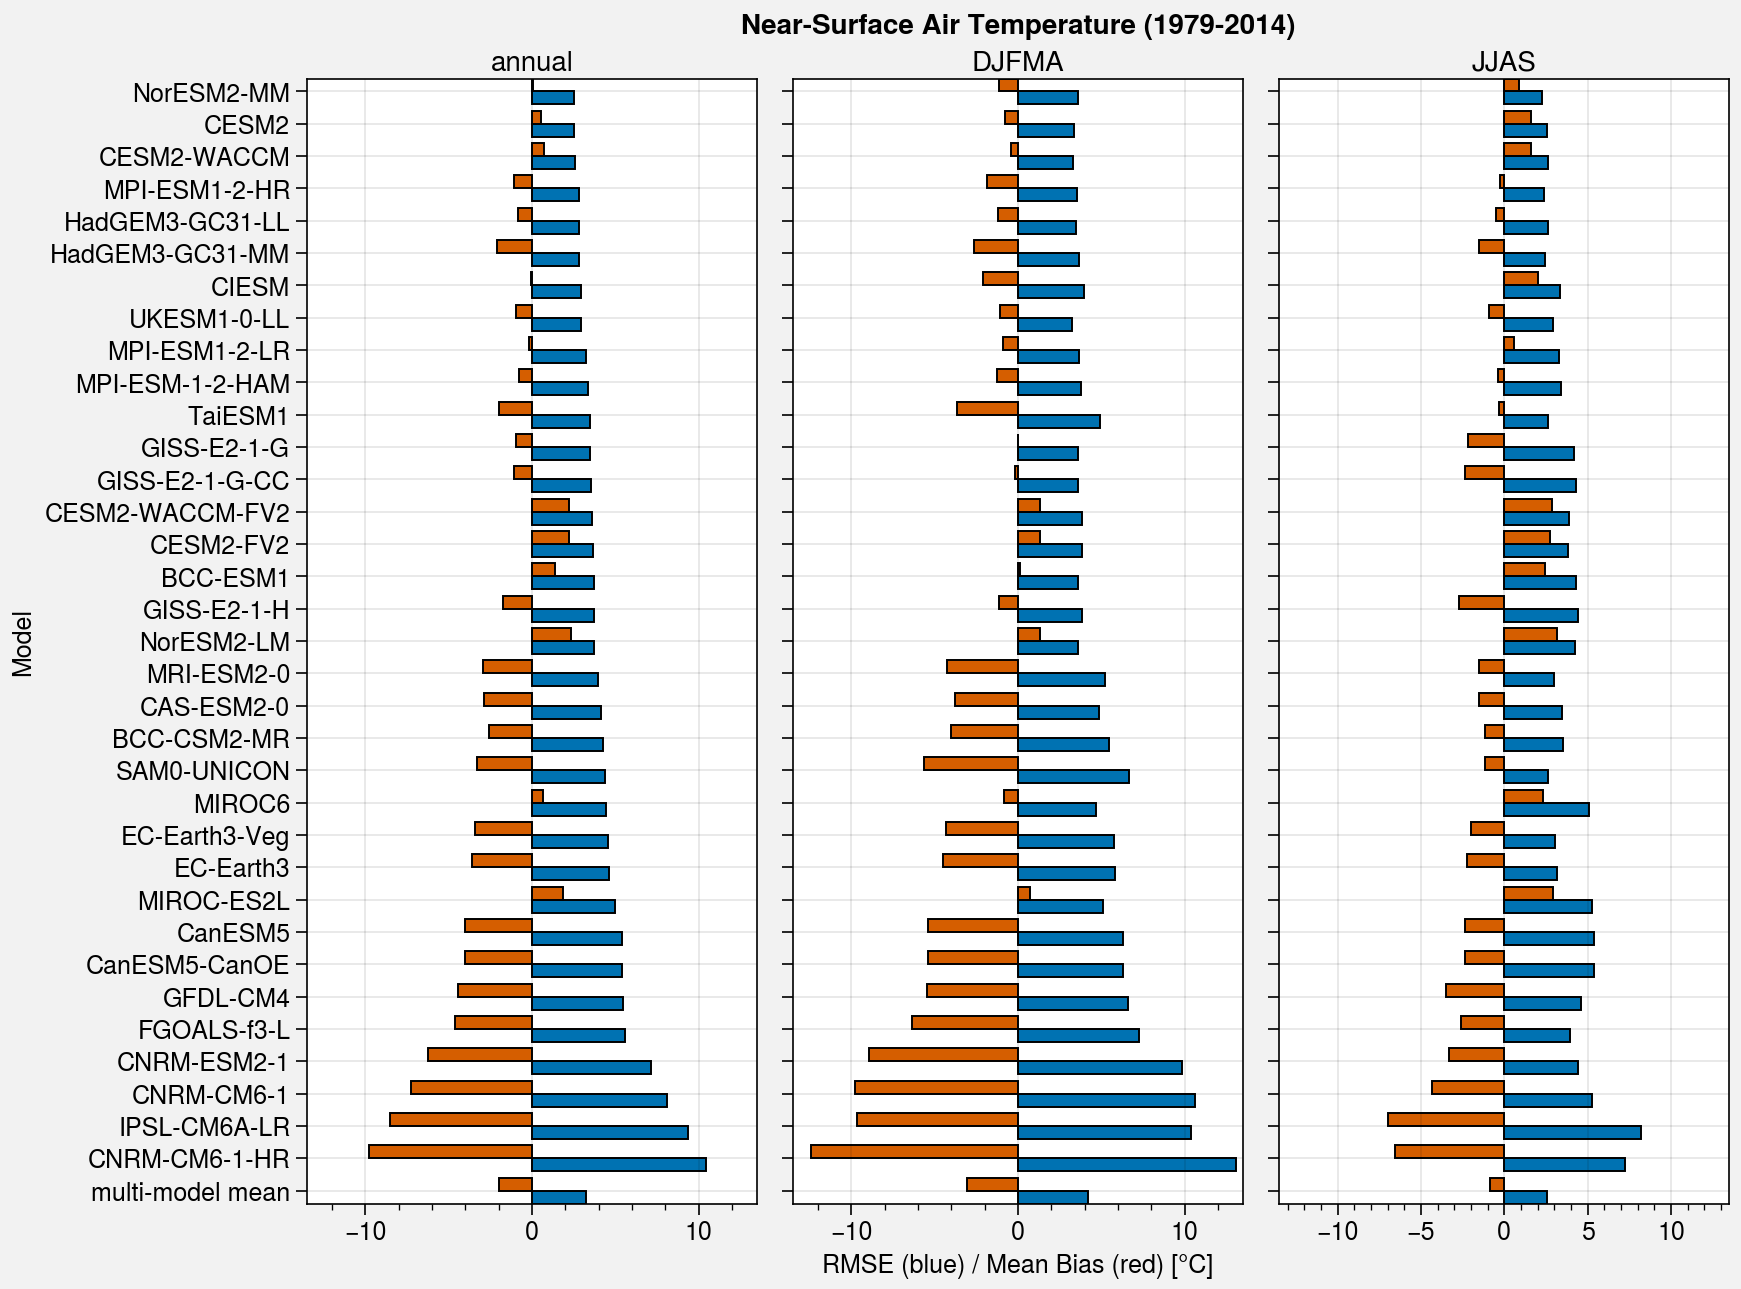

In [190]:
f, axs = plot.subplots(ncols=3, aspect=0.4)

lim = 13.5
for i, ax in enumerate(axs):
    m = ax.barh(list_data[i])

    ax.format(
        title = multimodel_ensemble_bias_mmm.isel(season=i).season.values,
        xlim = (-lim,lim), xlabel = 'RMSE (blue) / Mean Bias (red) ['+units+']',
        suptitle = label+' ('+period.start+'-'+period.stop+')'
    )
    
filename = 'metrics_'+var+'_'+period.start+'-'+period.stop
f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')